# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [3]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = ((1 + riskfree/100).pow(1/252)-1)

In [4]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [5]:
# Create a list of semiannual dates to split on
rets_bt = rets[rets.index <= '2016-02-28']
dates_to_split = pd.date_range(rets_bt.index[0], rets_bt.index[-1], freq='M')

# Split on these dates
semiannual_bt = {}

for i in range(len(dates_to_split)-1):
    semiannual_bt[i] = rets_bt[dates_to_split[i]:dates_to_split[i+1]]

rets_p = rets[rets.index >= '2016-02-28']
dates_to_split = pd.date_range(rets_p.index[0], rets_p.index[-1], freq='M')

# Split on these dates
semiannual_p = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual_p[i] = rets_p[dates_to_split[i]:dates_to_split[i+1]]

# Lowest correlation Search

In [6]:
top10_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs =  ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top10_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top15_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]

top20_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top20_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_bt[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

top10_p = {}
for i in range(1,len(semiannual_p)):
    corrs =  ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top10_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top15_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]
    
top20_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top20_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_p[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

# Portfolio weight optimization -- Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [7]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer
import Risk_analytics

from importlib import reload
reload(portfolio_optimizer)
reload(Risk_analytics)

from portfolio_optimizer import portfolio_optimizer

In [8]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':5000,'VaR99':5800,'CVaR95':5700,'CVaR99':5400}

In [9]:
# Benchmark PnL
k = benchmark_ret
benchmark_pnl = pd.DataFrame()
benchmark_pnl['return'] = k
benchmark_pnl['capital'] = 100000
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
for i in range(len(dates_to_split)-1):
    benchmark_pnl.loc[dates_to_split[i]:dates_to_split[i+1],'capital'] = 100000+ (i+1)*10000
benchmark_pnl.loc[dates_to_split[len(dates_to_split)-1]:,'capital']=  100000+ len(dates_to_split)*10000
benchmark_pnl['PnL'] = benchmark_pnl['return']*benchmark_pnl['capital']

benchmark_pnl_bt = benchmark_pnl[benchmark_pnl.index <= '03/31/2016']
benchmark_pnl_p = benchmark_pnl[benchmark_pnl.index >= '03/31/2016']

# Backtesting results - without options

10 cutoff ETFs

In [10]:
opt10_bt = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Sharpe ratio maximization', 0)

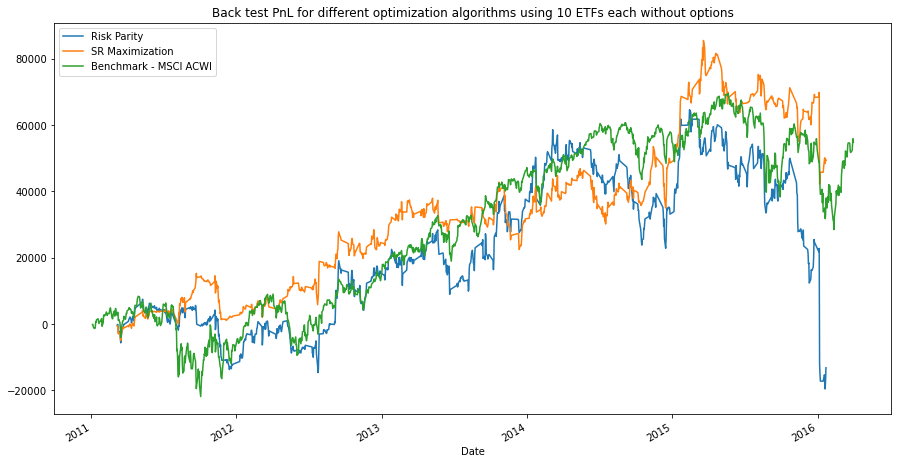

In [11]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 10 ETFs each without options')
plt.legend()
plt.show()

In [12]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

-0.1884
0.8983
-51.15%
-23.34%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -2218.100814  -2388.768001  -2559.435188  -2559.435188
2011-04-29 -1087.607711  -1503.062964  -1918.518218  -1918.518218
2011-05-31 -3016.223036  -4009.618877  -5003.014719  -5003.014719
2011-06-30 -1252.930294  -1353.559666  -1454.189038  -1454.189038
2011-07-29 -1747.714932  -2279.766093  -2811.817254  -2811.817254
2011-08-31 -5889.883893  -6959.420279  -8028.956666  -8028.956666
2011-09-30 -2736.769445  -3396.142793  -4055.516140  -4055.516140
2011-10-31 -1475.803011  -1708.172767  -1940.542523  -1940.542523
2011-11-30 -4963.862072  -5566.453177  -6169.044282  -6169.044282
2011-12-30 -1694.435508  -1902.632112  -2110.828716  -2110.828716
2012-01-31 -1527.302900  -1630.340616  -1733.378333  -1733.378333
2012-02-29 -2230.150074  -3851.220521  -5472.290969  -5472.290969
2012-03-30 -2929.762340  -4457.636759  -5985.

15 cutoff ETFs

In [13]:
opt15_bt = portfolio_optimizer(semiannual_bt)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization', 0)

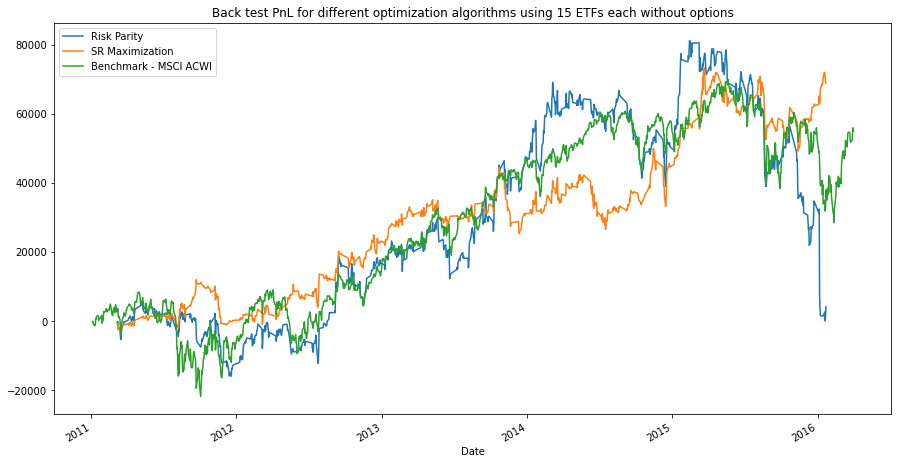

In [14]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 15 ETFs each without options')
plt.legend()
plt.show()

In [15]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

0.0625
1.701
-44.800000000000004%
-14.02%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -2039.784075  -2155.840274  -2271.896473  -2271.896473
2011-04-29  -994.835612  -1398.142749  -1801.449887  -1801.449887
2011-05-31 -2298.823550  -3059.810147  -3820.796745  -3820.796745
2011-06-30 -1272.840227  -1340.865509  -1408.890791  -1408.890791
2011-07-29 -1605.672256  -2243.487463  -2881.302671  -2881.302671
2011-08-31 -5080.610198  -6199.462654  -7318.315110  -7318.315110
2011-09-30 -3194.729634  -3314.207542  -3433.685449  -3433.685449
2011-10-31 -1589.422918  -2174.976334  -2760.529750  -2760.529750
2011-11-30 -5327.520640  -6035.257233  -6742.993825  -6742.993825
2011-12-30 -2231.519707  -2295.871410  -2360.223114  -2360.223114
2012-01-31 -1465.696817  -1480.227125  -1494.757434  -1494.757434
2012-02-29 -1611.180804  -3081.281229  -4551.381654  -4551.381654
2012-03-30 -2726.233260  -4310.325

20 cutoff ETFs

In [16]:
opt20_bt = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Sharpe ratio maximization', 0)

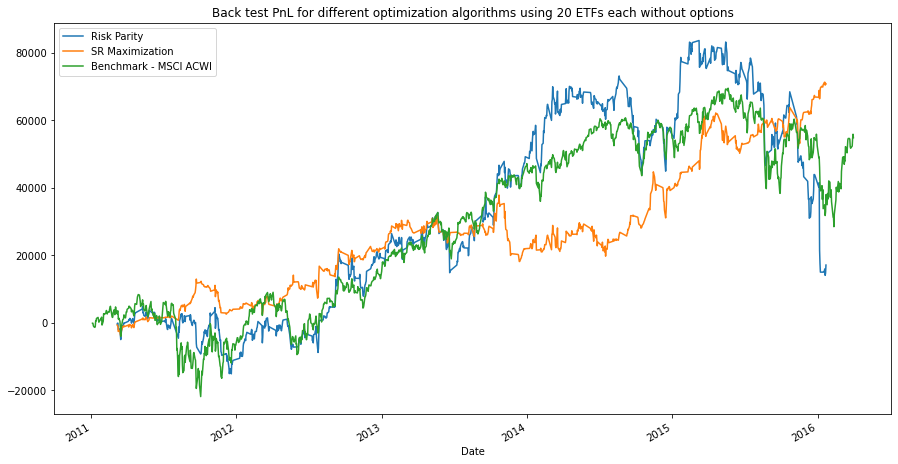

In [17]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 20 ETFs each without options')
plt.legend()
plt.show()

In [18]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

0.2768
2.0458
-37.89%
-14.280000000000001%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -1820.820753  -2025.802684  -2230.784616  -2230.784616
2011-04-29  -852.737652  -1277.201158  -1701.664664  -1701.664664
2011-05-31 -2105.195419  -2662.777575  -3220.359731  -3220.359731
2011-06-30 -1592.595665  -1615.086671  -1637.577677  -1637.577677
2011-07-29 -1534.104063  -2077.960698  -2621.817333  -2621.817333
2011-08-31 -4786.903017  -5726.609396  -6666.315775  -6666.315775
2011-09-30 -3041.276603  -3622.196952  -4203.117301  -4203.117301
2011-10-31 -2048.190134  -2615.602492  -3183.014850  -3183.014850
2011-11-30 -5053.968515  -5694.604980  -6335.241444  -6335.241444
2011-12-30 -2984.422705  -3118.966779  -3253.510852  -3253.510852
2012-01-31 -1452.098795  -1489.160108  -1526.221422  -1526.221422
2012-02-29 -1602.185846  -2835.201268  -4068.216689  -4068.216689
2012-03-30 -2363.383076  -3859.96

# Portfolio Performance

10 cutoff - 0 leverage options

In [19]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 0)

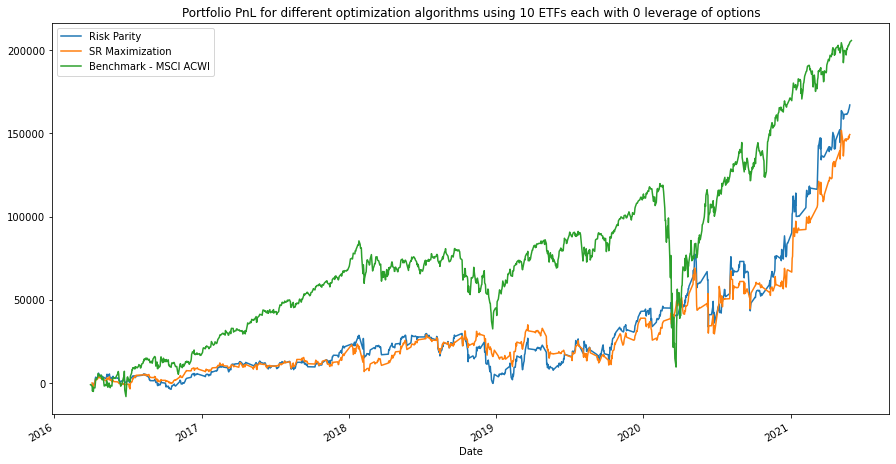

In [20]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [21]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.947
1.9366
-24.740000000000002%
-23.43%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1214.466641  -1517.899211  -1821.331780  -1821.331780
2016-05-31  -2606.796678  -3137.384488  -3667.972299  -3667.972299
2016-06-30  -1290.916022  -1957.579657  -2624.243292  -2624.243292
2016-07-29  -1171.397367  -1556.302450  -1941.207532  -1941.207532
2016-08-31  -1129.816120  -1568.513959  -2007.211799  -2007.211799
...                  ...           ...           ...           ...
2021-01-29 -13487.096718 -14300.771660 -15114.446602 -15114.446602
2021-02-26  -9589.949687  -9589.949687  -9589.949687  -9589.949687
2021-03-31 -12820.247241 -14631.617144 -16442.987048 -16442.987048
2021-04-30  -5805.907227  -7456.062584  -9106.217940  -9106.217940
2021-05-31 -10173.239941 -12463.213250 -14753.186560 -14753.186560

[62 rows x 4 columns]
                  VaR95       CVaR95         VaR99        CVaR99

10 cutoff - 10 leverage options

In [22]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 10)

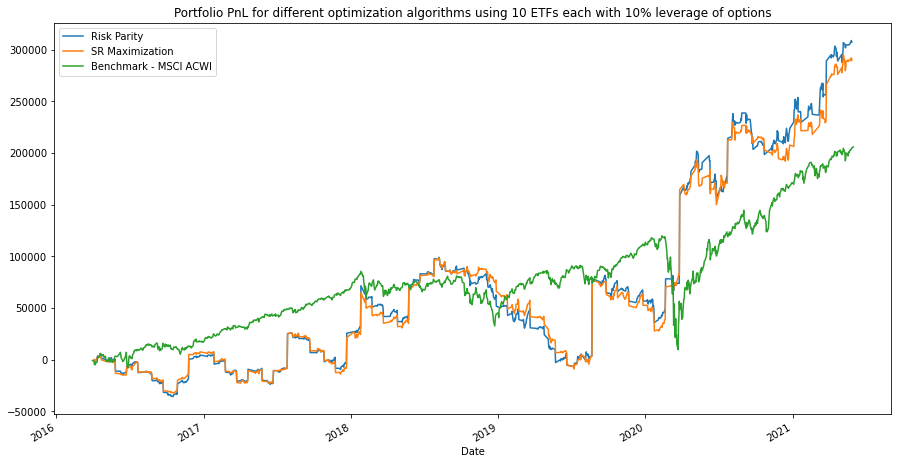

In [23]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [24]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.6624
1.6004
-53.83%
-54.120000000000005%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6674.923121  -8276.931557  -9310.905754 -10154.799214
2016-05-31  -7248.773248  -8869.395878  -9743.418459 -11215.843819
2016-06-30  -4760.038614  -6354.023995  -7641.055638  -8270.512856
2016-07-29  -4347.762279  -5552.101618  -6462.563836  -6950.611612
2016-08-31  -4772.474188  -6184.867835  -7052.038027  -8075.093199
...                  ...           ...           ...           ...
2021-01-29 -18002.698374 -20129.839276 -21526.252970 -22789.341506
2021-02-26 -14680.359297 -15832.901232 -16656.598928 -17396.636614
2021-03-31 -18888.847659 -21935.010940 -24406.969946 -25948.681744
2021-04-30 -12005.083503 -15336.821436 -18228.425720 -19573.094496
2021-05-31 -16213.525621 -20204.103593 -23594.791021 -24954.899014

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVa

10 cutoff - 20 leverage options

In [25]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 20)

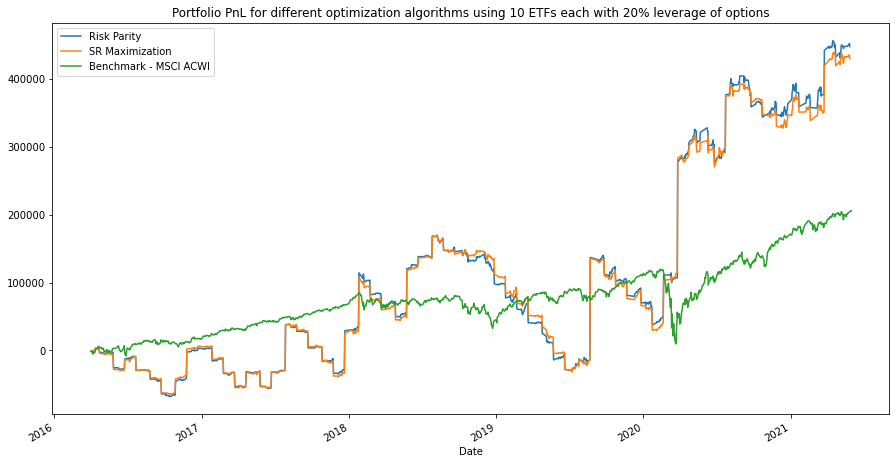

In [26]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [27]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.3193
1.2751
-74.33%
-74.6%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11489.084198 -14250.385745 -15922.575514 -18027.039709
2016-05-31 -12358.833028 -15688.008868 -17652.266749 -20624.207329
2016-06-30  -7884.189722 -10339.622963 -11967.506520 -13316.789936
2016-07-29  -7758.596199  -9641.486962 -11419.984204 -12358.428364
2016-08-31  -8415.171628 -10753.883443 -12119.463783 -14313.468483
...                  ...           ...           ...           ...
2021-01-29 -21962.200982 -24913.861724 -27041.689938 -28864.505002
2021-02-26 -20627.493673 -23792.810632 -25323.621752 -27599.893680
2021-03-31 -25109.933545 -30051.656350 -33520.170740 -36037.597314
2021-04-30 -18596.987083 -23050.704436 -26249.634336 -28471.270284
2021-05-31 -22739.900074 -28058.365943 -31977.087208 -35059.079371

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR99
Period    

15 cutoff - 0 leverage options

In [28]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 0)

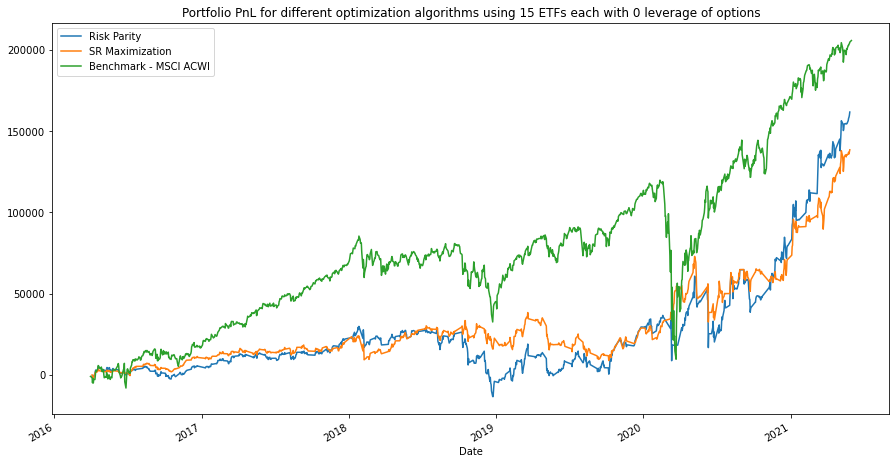

In [29]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [30]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.9178
1.9618
-33.29%
-23.369999999999997%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1178.241988  -1386.100112  -1593.958236  -1593.958236
2016-05-31  -1930.057750  -2529.933901  -3129.810052  -3129.810052
2016-06-30  -1088.886790  -1980.347419  -2871.808048  -2871.808048
2016-07-29  -1001.058487  -1245.995664  -1490.932841  -1490.932841
2016-08-31   -949.028940  -1309.004330  -1668.979719  -1668.979719
...                  ...           ...           ...           ...
2021-01-29 -12423.802929 -13429.241022 -14434.679115 -14434.679115
2021-02-26 -10103.130751 -10103.130751 -10103.130751 -10103.130751
2021-03-31 -10852.040149 -11701.497103 -12550.954057 -12550.954057
2021-04-30  -6387.256780  -7491.179719  -8595.102658  -8595.102658
2021-05-31  -9093.666505 -10583.935488 -12074.204471 -12074.204471

[62 rows x 4 columns]
                  VaR95        CVaR95         VaR99        CVaR

15 cutoff - 10 leverage options

In [31]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 10)

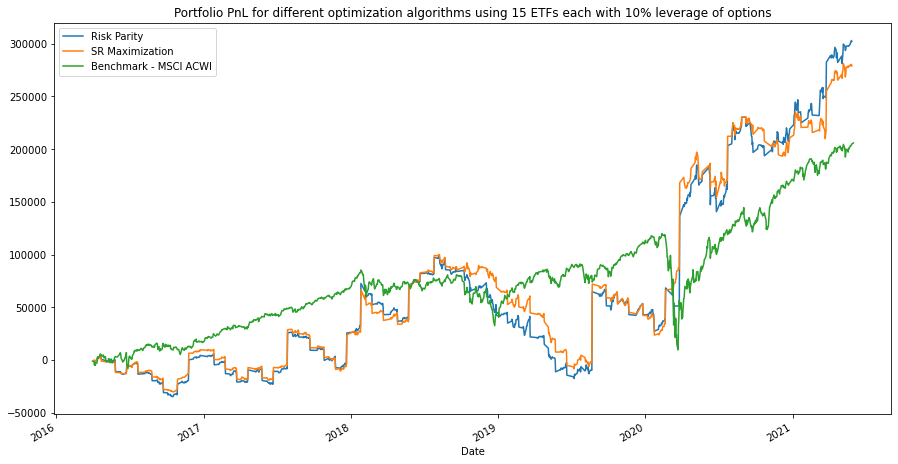

In [32]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [33]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.6382
1.5585
-58.379999999999995%
-54.2%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6638.698468  -8145.132458  -9083.532210  -9927.425670
2016-05-31  -6572.034320  -8261.945291  -9205.256212 -10677.681572
2016-06-30  -4558.009382  -6376.791757  -7888.620394  -8518.077612
2016-07-29  -4177.423399  -5241.794832  -6012.289145  -6500.336921
2016-08-31  -4591.687008  -5925.358206  -6713.805947  -7736.861119
...                  ...           ...           ...           ...
2021-01-29 -16939.404585 -19258.308638 -20846.485483 -22109.574019
2021-02-26 -15193.540361 -16346.082296 -17169.779992 -17909.817678
2021-03-31 -16920.640567 -19004.890899 -20514.936955 -22056.648753
2021-04-30 -12586.433056 -15371.938571 -17717.310438 -19061.979214
2021-05-31 -15133.952185 -18324.825831 -20915.808932 -22275.916925

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR

15 cutoff - 20 leverage options

In [34]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20)

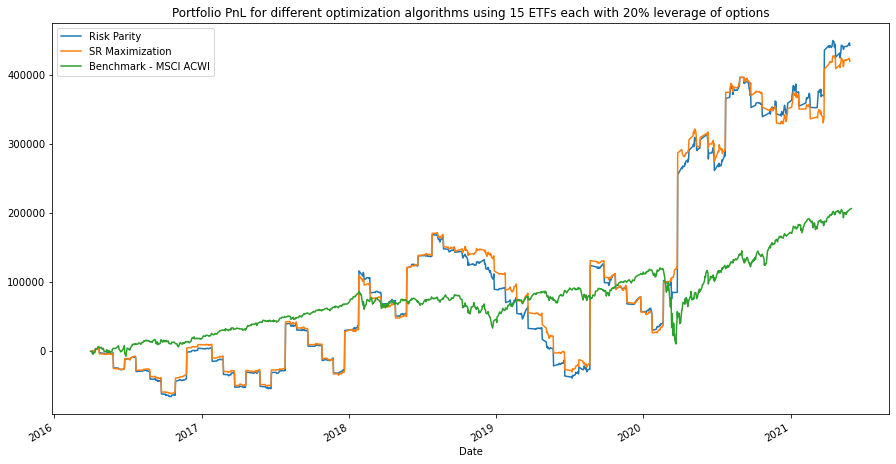

In [35]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [36]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.3044
1.246
-77.73%
-74.51%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11452.859545 -14118.586646 -15695.201970 -17799.666165
2016-05-31 -11682.094100 -15080.558281 -17114.104502 -20086.045082
2016-06-30  -7682.160490 -10362.390725 -12215.071276 -13564.354692
2016-07-29  -7588.257319  -9331.180176 -10969.709513 -11908.153673
2016-08-31  -8234.384448 -10494.373814 -11781.231703 -13975.236403
...                  ...           ...           ...           ...
2021-01-29 -20898.907193 -24042.331086 -26361.922451 -28184.737515
2021-02-26 -21140.674737 -24305.991696 -25836.802816 -28113.074744
2021-03-31 -23141.726453 -27121.536309 -29628.137749 -32145.564323
2021-04-30 -19178.336636 -23085.821571 -25738.519054 -27960.155002
2021-05-31 -21660.326638 -26179.088181 -29298.105119 -32380.097282

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR99
Period    

20 cutoff - 0 leverage options

In [37]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 0)

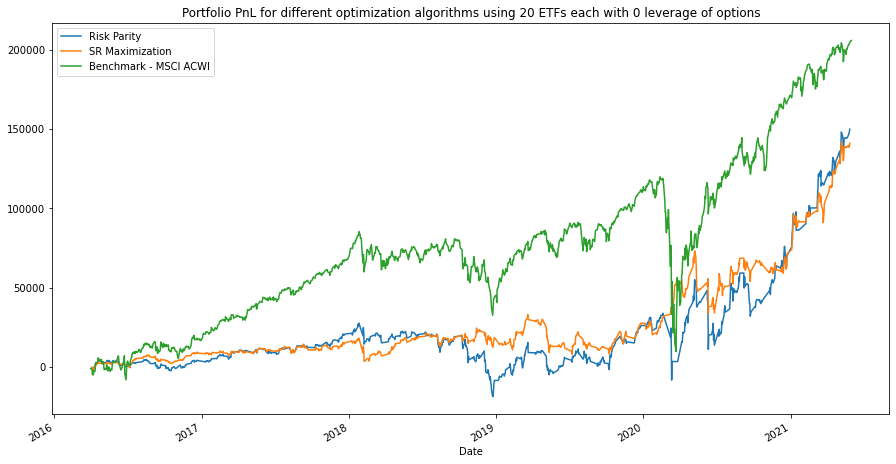

In [38]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [39]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.7568
2.0797
-36.3%
-22.73%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1156.788983  -1275.153960  -1393.518936  -1393.518936
2016-05-31  -1627.961301  -2116.840110  -2605.718918  -2605.718918
2016-06-30  -1256.971468  -2321.448148  -3385.924828  -3385.924828
2016-07-29   -874.723347  -1063.423124  -1252.122901  -1252.122901
2016-08-31   -814.646335  -1094.085299  -1373.524264  -1373.524264
...                  ...           ...           ...           ...
2021-01-29 -13027.843308 -14070.083851 -15112.324395 -15112.324395
2021-02-26  -9291.487836  -9291.487836  -9291.487836  -9291.487836
2021-03-31  -9817.738910 -10369.454286 -10921.169662 -10921.169662
2021-04-30  -5651.081233  -6670.097886  -7689.114538  -7689.114538
2021-05-31  -8800.976377 -10566.409122 -12331.841868 -12331.841868

[62 rows x 4 columns]
                  VaR95        CVaR95         VaR99        CVaR99
Period     

20 cutoff - 10 leverage options

In [40]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 10)

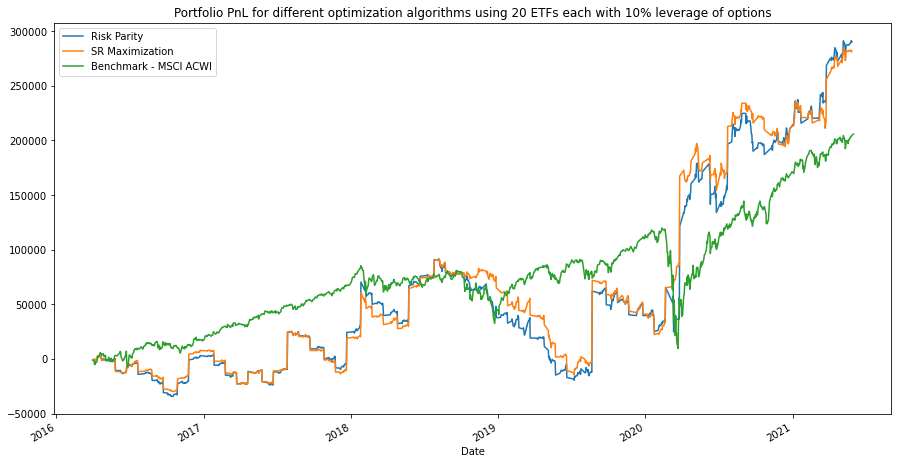

In [41]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [42]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.5697
1.5794
-58.050000000000004%
-55.410000000000004%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6617.245463  -8034.186306  -8883.092910  -9726.986370
2016-05-31  -6269.937871  -7848.851500  -8681.165078 -10153.590438
2016-06-30  -4726.094060  -6717.892486  -8402.737174  -9032.194392
2016-07-29  -4051.088259  -5059.222292  -5773.479205  -6261.526981
2016-08-31  -4457.304403  -5710.439175  -6418.350492  -7441.405664
...                  ...           ...           ...           ...
2021-01-29 -17543.444964 -19899.151467 -21524.130763 -22787.219299
2021-02-26 -14381.897446 -15534.439381 -16358.137077 -17098.174763
2021-03-31 -15886.339328 -17672.848082 -18885.152560 -20426.864358
2021-04-30 -11850.257509 -14550.856738 -16811.322318 -18155.991094
2021-05-31 -14841.262057 -18307.299465 -21173.446329 -22533.554322

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR

20 cutoff - 20 leverage options

In [43]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 20)

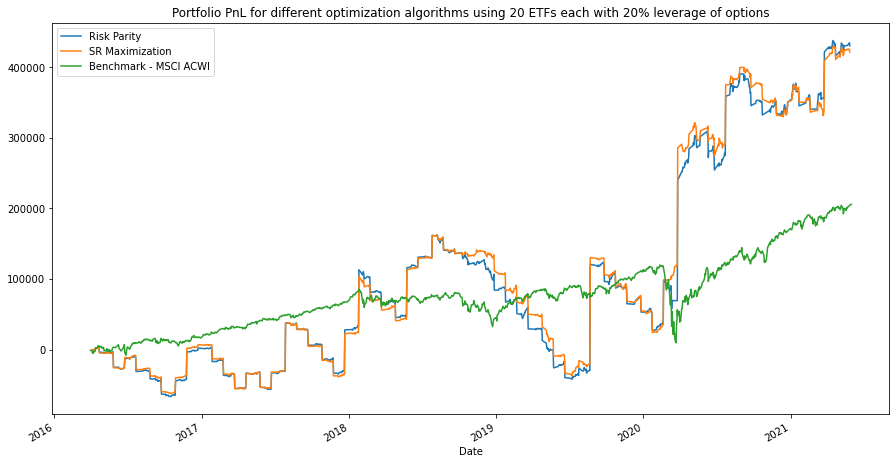

In [44]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [45]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.2682
1.2546
-77.97%
-76.07000000000001%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11431.406540 -14007.640494 -15494.762670 -17599.226865
2016-05-31 -11379.997651 -14667.464490 -16590.013368 -19561.953948
2016-06-30  -7850.245168 -10703.491454 -12729.188056 -14078.471472
2016-07-29  -7461.922179  -9148.607636 -10730.899573 -11669.343733
2016-08-31  -8100.001843 -10279.454783 -11485.776248 -13679.780948
...                  ...           ...           ...           ...
2021-01-29 -21502.947572 -24683.173915 -27039.567731 -28862.382795
2021-02-26 -20329.031822 -23494.348781 -25025.159901 -27301.431829
2021-03-31 -22107.425214 -25789.493492 -27998.353354 -30515.779928
2021-04-30 -18442.161089 -22264.739738 -24832.530934 -27054.166882
2021-05-31 -21367.636510 -26161.561815 -29555.742516 -32637.734679

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR

# Scenario Analysis

As the scenario testing, three scenarios will be tested:
1. the entire market will crash by half with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.
3. each ETFs will crush by moving average

In [69]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20, scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='Market crash')

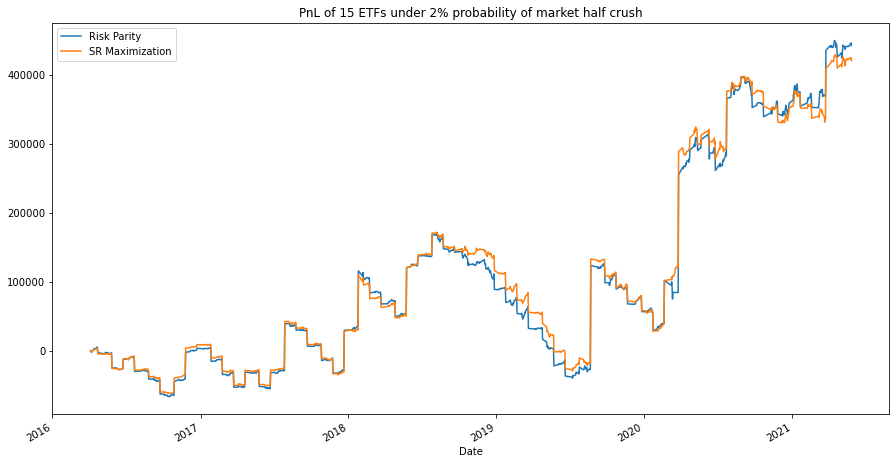

In [70]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market half crush')
plt.legend()
plt.show()

In [71]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859614,-14118.586717,-15695.202043,-17799.666238
2016-05-31,-11682.094078,-15080.558266,-17114.104494,-20086.045074
2016-06-30,-7682.160500,-10362.390740,-12215.071296,-13564.354712
2016-07-29,-7588.257322,-9331.180180,-10969.709517,-11908.153677
2016-08-31,-8234.384451,-10494.373818,-11781.231708,-13975.236408
...,...,...,...,...
2021-01-29,-20898.907295,-24042.331188,-26361.922554,-28184.737618
2021-02-26,-21140.674814,-24305.991773,-25836.802893,-28113.074821
2021-03-31,-23141.726619,-27121.536469,-29628.137903,-32145.564477


In [72]:
overallrisk_rp.sum(axis=1)

Period
2016-04-29    -59066.314612
2016-05-31    -63962.801912
2016-06-30    -43823.977249
2016-07-29    -39797.300697
2016-08-31    -44485.226384
                  ...      
2021-01-29    -99487.898655
2021-02-26    -99396.544301
2021-03-31   -112036.965466
2021-04-30    -95962.832479
2021-05-31   -109517.617514
Length: 62, dtype: float64

In [73]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -74.09%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11363.605141,-14176.434448,-15900.151978,-18004.616173
2016-05-31,-11162.046786,-14500.546124,-16474.127501,-19446.068081
2016-06-30,-6992.530346,-9001.082273,-10182.084516,-11531.367932
2016-07-29,-7488.908198,-9608.236594,-11623.171471,-12561.615631
2016-08-31,-8117.345701,-10265.779688,-11441.082198,-13635.086898
...,...,...,...,...
2021-01-29,-18001.148706,-21656.242652,-24487.504069,-26310.319133
2021-02-26,-17267.237637,-20432.554596,-21963.365716,-24239.637644
2021-03-31,-17780.965025,-22252.310039,-25250.446637,-27767.873211


In [74]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20, scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='Random ETF crash')


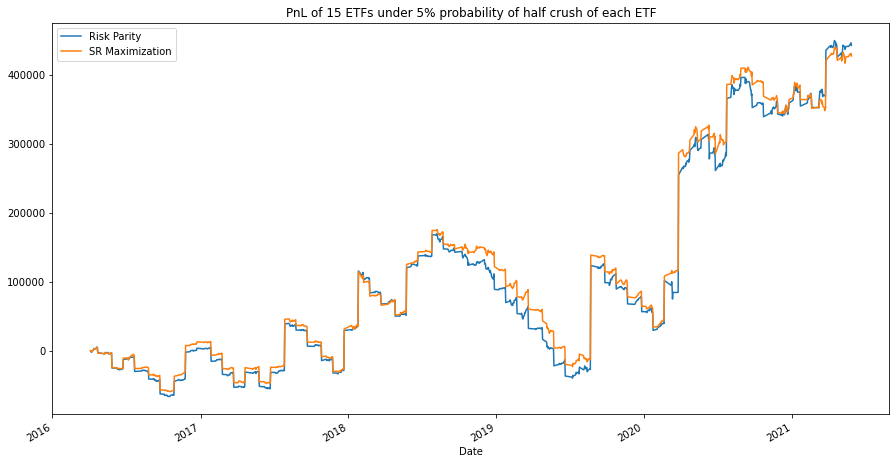

In [75]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [76]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859597,-14118.586681,-15695.201988,-17799.666183
2016-05-31,-11682.094085,-15080.558301,-17114.104557,-20086.045137
2016-06-30,-7682.160465,-10362.390690,-12215.071230,-13564.354646
2016-07-29,-7588.257408,-9331.180178,-10969.709428,-11908.153588
2016-08-31,-8234.384692,-10494.374094,-11781.232021,-13975.236721
...,...,...,...,...
2021-01-29,-20898.907189,-24042.330953,-26361.922189,-28184.737253
2021-02-26,-21140.675533,-24305.992492,-25836.803612,-28113.075540
2021-03-31,-23141.721043,-27121.531817,-29628.134175,-32145.560749


In [77]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -72.13000000000001%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11120.711152,-13965.567536,-15721.312143,-17825.776338
2016-05-31,-11016.226658,-14365.914020,-16350.683422,-19322.624002
2016-06-30,-7093.249659,-9149.007657,-10377.215970,-11726.499386
2016-07-29,-7830.444158,-10169.065600,-12403.293522,-13341.737682
2016-08-31,-8212.862433,-10376.766621,-11567.539333,-13761.544033
...,...,...,...,...
2021-01-29,-18112.888077,-21756.202763,-24575.684920,-26398.499984
2021-02-26,-17892.803848,-21058.120807,-22588.931927,-24865.203855
2021-03-31,-19745.353789,-23406.157363,-25593.752521,-28111.179095


In [78]:
# MV crush scenario
opt_sa1 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity',20, scenario='MV ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='MV ETF crash')

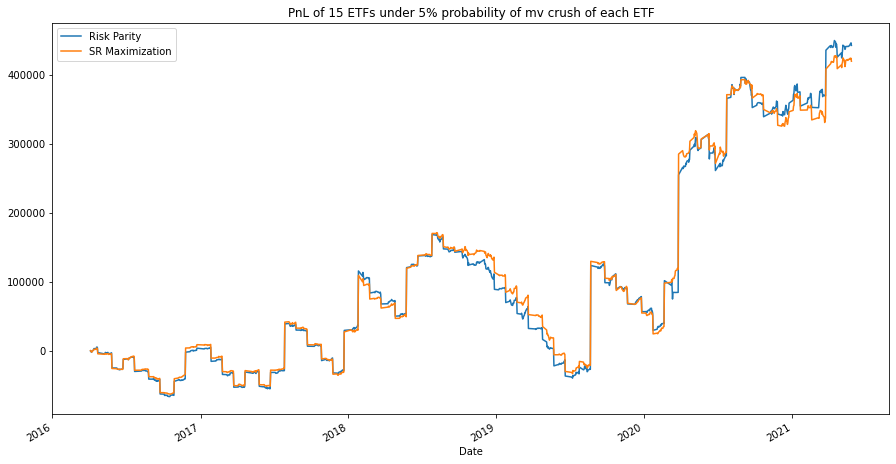

In [79]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of mv crush of each ETF')
plt.legend()
plt.show()

In [80]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859545,-14118.586646,-15695.201970,-17799.666165
2016-05-31,-11682.094100,-15080.558281,-17114.104502,-20086.045082
2016-06-30,-7682.160490,-10362.390725,-12215.071276,-13564.354692
2016-07-29,-7588.257319,-9331.180176,-10969.709513,-11908.153673
2016-08-31,-8234.384448,-10494.373814,-11781.231703,-13975.236403
...,...,...,...,...
2021-01-29,-20898.909904,-24042.334016,-26361.925600,-28184.740664
2021-02-26,-21140.676909,-24305.993868,-25836.804988,-28113.076916
2021-03-31,-23141.728915,-27121.538732,-29628.140133,-32145.566707


In [81]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -75.47%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11357.367977,-14168.231421,-15889.983088,-17994.447283
2016-05-31,-11161.758463,-14500.147397,-16473.618372,-19445.558952
2016-06-30,-6992.332000,-9008.188324,-10196.494963,-11545.778379
2016-07-29,-7488.779250,-9608.018792,-11622.864814,-12561.308974
2016-08-31,-8118.749802,-10267.341448,-11442.801618,-13636.806318
...,...,...,...,...
2021-01-29,-16597.889328,-20977.836094,-24533.950332,-26356.765396
2021-02-26,-17862.956796,-21028.273755,-22559.084875,-24835.356803
2021-03-31,-17718.377926,-21913.630955,-24635.675568,-27153.102142
